# **Animal Image Classification Using Deep Learning**

This notebook trains a deep learning model to classify images of animals. We will follow a structured approach:


Install & Import Dependencies

Unzip & Load the Dataset

Explore the Data

Data Preprocessing & Augmentation

Build the CNN Model

Train the Model

Evaluate Model Performance

Test on the Validation Set

Save the Model

Test on New Images

Future Improvements



**Preprocess the data – Resize images, normalize pixel values**

**Define the model – CNN (Convolutional Neural Network)**

**Train the model – Using TensorFlow/Keras**

**Evaluate performance – Accuracy, loss, confusion matrix**

**Make predictions – Test on sample images**

#Step 1: Install & Import Dependencies

Before starting, we need to import necessary libraries for deep learning, image processing, and visualization.

In [1]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD

# Step 2: Unzip & Load the Dataset

We extract the dataset from the ZIP file and organize image paths.

In [3]:
import zipfile

# Define the uploaded file name
zip_path = "/content/animaldata.zip"  # Ensure this matches your uploaded file

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/animaldata")

# Define dataset paths
dataset_dir = "/content/animaldata/animals/animals"
labels_file = "/content/animaldata/nameanimals.txt"

# Read class labels
with open(labels_file, 'r') as f:
    class_labels = [line.strip() for line in f.readlines()]

print("Classes:", class_labels)


Classes: ['antelope', 'badger', 'bat', 'bear', 'bee', 'beetle', 'bison', 'boar', 'butterfly', 'cat', 'caterpillar', 'chimpanzee', 'cockroach', 'cow', 'coyote', 'crab', 'crow', 'deer', 'dog', 'dolphin', 'donkey', 'dragonfly', 'duck', 'eagle', 'elephant', 'flamingo', 'fly', 'fox', 'goat', 'goldfish', 'goose', 'gorilla', 'grasshopper', 'hamster', 'hare', 'hedgehog', 'hippopotamus', 'hornbill', 'horse', 'hummingbird', 'hyena', 'jellyfish', 'kangaroo', 'koala', 'ladybugs', 'leopard', 'lion', 'lizard', 'lobster', 'mosquito', 'moth', 'mouse', 'octopus', 'okapi', 'orangutan', 'otter', 'owl', 'ox', 'oyster', 'panda', 'parrot', 'pelecaniformes', 'penguin', 'pig', 'pigeon', 'porcupine', 'possum', 'raccoon', 'rat', 'reindeer', 'rhinoceros', 'sandpiper', 'seahorse', 'seal', 'shark', 'sheep', 'snake', 'sparrow', 'squid', 'squirrel', 'starfish', 'swan', 'tiger', 'turkey', 'turtle', 'whale', 'wolf', 'wombat', 'woodpecker', 'zebra']


In [ ]:
from google.colab import drive

# Unmount Google Drive
drive.flush_and_unmount()

print("Google Drive has been disconnected.")


Google Drive has been disconnected.


# Step 3: Load and Explore the Data

Load and visualize some images to understand the dataset.

Collect All Image Paths from Subfolders

Found 5400 images in 90 categories.


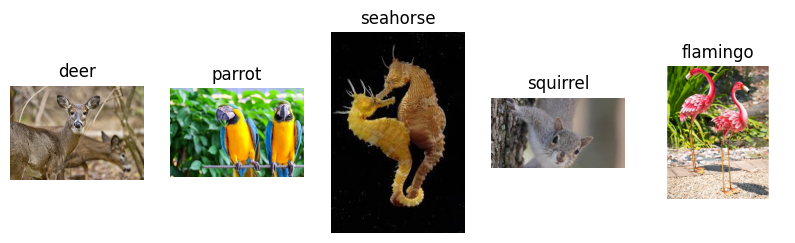

In [5]:
import os
import random
import cv2
import matplotlib.pyplot as plt

# Path to the main dataset folder
dataset_dir = "/content/animaldata/animals/animals"

# Collect all image paths
image_files = []
for animal in os.listdir(dataset_dir):  # Loop through each animal folder
    animal_path = os.path.join(dataset_dir, animal)
    if os.path.isdir(animal_path):  # Check if it's a folder
        for img in os.listdir(animal_path):
            if img.lower().endswith(('.jpg', '.jpeg', '.png')):  # Filter images
                image_files.append(os.path.join(animal_path, img))

# Check if images are available
if len(image_files) == 0:
    print("No images found in the dataset directory.")
else:
    print(f"Found {len(image_files)} images in {len(os.listdir(dataset_dir))} categories.")

    # Display 5 random images
    plt.figure(figsize=(10, 5))
    for i in range(min(5, len(image_files))):  # Handle cases where <5 images exist
        img_path = random.choice(image_files)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.title(img_path.split("/")[-2])  # Show category name
        plt.axis("off")

    plt.show()


# Step 4: Data Preprocessing & Augmentation

We'll use ImageDataGenerator to:

Rescale pixel values to [0,1]

Apply data augmentation (rotation, zoom, flipping, etc.) to prevent overfitting

In [6]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# ✅ Optimized Image Size
IMG_SIZE = (240, 240)
BATCH_SIZE = 32
NUM_CLASSES = 90

# ✅ Optimized Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    validation_split=0.2
)

# ✅ Load Dataset
dataset_dir = "/content/animaldata/animals/animals"

train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    subset="validation"
)


Found 4320 images belonging to 90 classes.
Found 1080 images belonging to 90 classes.


# Step 5: Build the CNN Model

We'll define a CNN architecture with:

3 convolutional layers for feature extraction

MaxPooling layers for dimensionality reduction

Dropout for regularization

Fully connected layers for classification

In [ ]:
# Define CNN Model
model = Sequential([
    Input(shape=(150, 150, 3)),  # Input layer with image shape

    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Prevent overfitting
    Dense(NUM_CLASSES, activation='softmax')  # Output layer
])


In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])


In [ ]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 90)                  │          46,170 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,079,834 (72.78 MB)

 Trainable params: 19,079,834 (72.78 MB)

 Non-trainable params: 0 (0.00 B)

# Step 6: Load Pretrained Model EfficientNet80

We initially implemented a Convolutional Neural Network (CNN) from scratch, but the results were not very promising:

Low Accuracy (~20%) even after multiple epochs
Slow Convergence – learning was very slow
Overfitting Issues – validation accuracy was not improving significantly
🚀 Why Switch to MobileNetV2?
Given the challenges with CNN, we decided to use MobileNetV2, a pretrained deep learning model optimized for image classification. It provides:
✅ Higher accuracy due to transfer learning from ImageNet
✅ Faster training as it already knows general image features
✅ Less overfitting since it's trained on a large dataset


While MobileNetV2 improved performance(~50%), we wanted to further enhance accuracy and efficiency.

EfficientNetB0 offers:

✅ Better Accuracy – Uses Neural Architecture Search (NAS) to optimize model performance.
✅ Efficient Training – Balances model size, accuracy, and speed.
✅ Better Generalization – Handles overfitting better than traditional CNNs.

In [7]:
# ✅ Load Pretrained MobileNetV2
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model.trainable = False  # Freeze the base model

# ✅ Build Model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.4),
    Dense(512, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation="softmax", dtype="float32")  # Ensure correct dtype for mixed precision
])

# ✅ Optimized Optimizer (Adam with LR scheduling)
optimizer = Adam(learning_rate=0.001)


<ipython-input-7-63948677d0b7>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

#Model Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 8, 8, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 90)                  │          46,170 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,967,194 (11.32 MB)

 Trainable params: 705,626 (2.69 MB)

 Non-trainable params: 2,261,568 (8.63 MB)

 # Step 7: Train the Model

In [9]:
EPOCHS = 20

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 140s 917ms/step - accuracy: 0.2555 - loss: 3.5413 - val_accuracy: 0.6704 - val_loss: 1.3928
Epoch 2/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 107s 724ms/step - accuracy: 0.7082 - loss: 1.1089 - val_accuracy: 0.7463 - val_loss: 0.9578
Epoch 3/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 98s 728ms/step - accuracy: 0.7541 - loss: 0.8505 - val_accuracy: 0.7667 - val_loss: 0.9175
Epoch 4/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 98s 728ms/step - accuracy: 0.7962 - loss: 0.7121 - val_accuracy: 0.7611 - val_loss: 0.8684
Epoch 5/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 101s 749ms/step - accuracy: 0.8181 - loss: 0.6486 - val_accuracy: 0.7620 - val_loss: 0.8480
Epoch 6/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 99s 731ms/step - accuracy: 0.8269 - loss: 0.5911 - val_accuracy: 0.7685 - val_loss: 0.8284
Epoch 7/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 99s 735ms/step - accuracy: 0.8442 - loss: 0.5162 - val_accuracy: 0.7796 - val_loss: 0.8393
Epoch 8/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 99s 735ms/step - accuracy: 0.8505 - loss

# Step 8: Make Predictions on Samples

In [21]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Function to preprocess an image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(240, 240))  # Resize to match input shape
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize pixel values
    return img_array

# Path to test image
test_image_path = "sample_test.jpg"

# Preprocess image
img_array = preprocess_image(test_image_path)

In [22]:
# Make a prediction
predictions = model.predict(img_array)

# Get the class with highest probability
predicted_class = np.argmax(predictions)

print(f"Predicted Class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted Class: 86


it shows index, we need to get label

In [23]:
# Load training data to get class labels
train_generator = train_datagen.flow_from_directory(
    "/content/animaldata/animals/animals",  # Replace with actual path
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    subset="training"
)

# Get class indices (dictionary mapping)
class_indices = train_generator.class_indices  # Example: {'cat': 0, 'dog': 1, 'elephant': 2, ...}
class_labels = {v: k for k, v in class_indices.items()}  # Reverse mapping: {0: 'cat', 1: 'dog', 2: 'elephant', ...}

# Print to check if mapping is correct
print(class_labels)


Found 4320 images belonging to 90 classes.
{0: 'antelope', 1: 'badger', 2: 'bat', 3: 'bear', 4: 'bee', 5: 'beetle', 6: 'bison', 7: 'boar', 8: 'butterfly', 9: 'cat', 10: 'caterpillar', 11: 'chimpanzee', 12: 'cockroach', 13: 'cow', 14: 'coyote', 15: 'crab', 16: 'crow', 17: 'deer', 18: 'dog', 19: 'dolphin', 20: 'donkey', 21: 'dragonfly', 22: 'duck', 23: 'eagle', 24: 'elephant', 25: 'flamingo', 26: 'fly', 27: 'fox', 28: 'goat', 29: 'goldfish', 30: 'goose', 31: 'gorilla', 32: 'grasshopper', 33: 'hamster', 34: 'hare', 35: 'hedgehog', 36: 'hippopotamus', 37: 'hornbill', 38: 'horse', 39: 'hummingbird', 40: 'hyena', 41: 'jellyfish', 42: 'kangaroo', 43: 'koala', 44: 'ladybugs', 45: 'leopard', 46: 'lion', 47: 'lizard', 48: 'lobster', 49: 'mosquito', 50: 'moth', 51: 'mouse', 52: 'octopus', 53: 'okapi', 54: 'orangutan', 55: 'otter', 56: 'owl', 57: 'ox', 58: 'oyster', 59: 'panda', 60: 'parrot', 61: 'pelecaniformes', 62: 'penguin', 63: 'pig', 64: 'pigeon', 65: 'porcupine', 66: 'possum', 67: 'raccoon'

In [24]:
predictions = model.predict(img_array)

# Get the class index with the highest probability
predicted_class_index = np.argmax(predictions)

# Get class name from index
predicted_label = class_labels.get(predicted_class_index, "Unknown")

print(f"Predicted Class: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted Class: wolf


#Step 9: Evaluate on the Test Dataset

In [26]:
test_generator = train_datagen.flow_from_directory(
    "/content/animaldata/animals/animals",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=False
)

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


Found 5400 images belonging to 90 classes.
169/169 ━━━━━━━━━━━━━━━━━━━━ 98s 580ms/step - accuracy: 0.9350 - loss: 0.2653
Test Accuracy: 0.9350
Test Loss: 0.2536


In [27]:
model.save("animal_classification_model.h5")  # Save as an H5 file
print("Model saved successfully!")

Model saved successfully!


 # Step 10: Record the Metrics

169/169 ━━━━━━━━━━━━━━━━━━━━ 105s 601ms/step


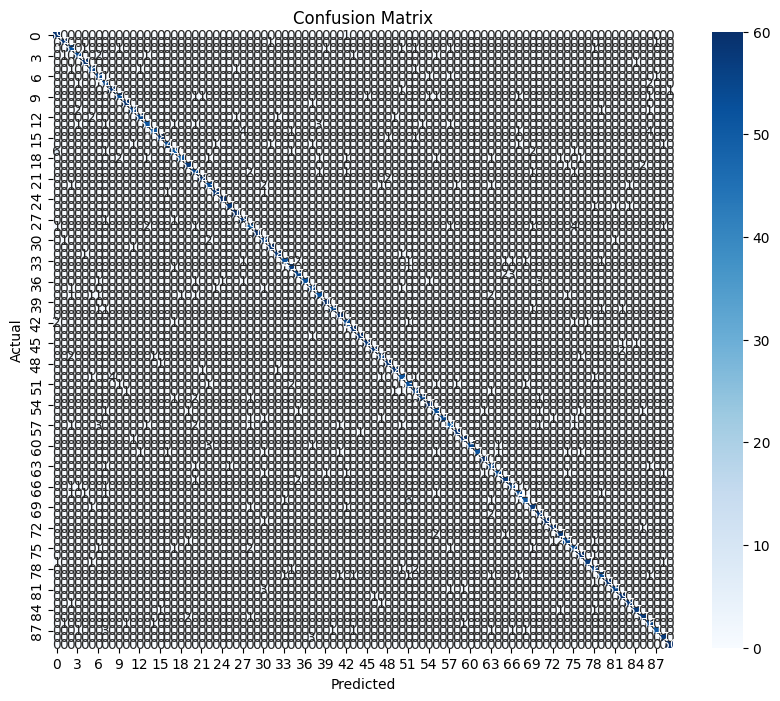

In [28]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Predict on test data
y_true = test_generator.classes  # Actual labels
y_pred = np.argmax(model.predict(test_generator), axis=1)  # Predicted labels

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot it
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Step 11: Hyperparameter Tuning & Regularization

In [29]:
from tensorflow.keras.layers import Dropout

# Example: Add dropout after a Dense layer
model.add(Dropout(0.5))  # 50% dropout

# Step 12: Conclusion & Future Work

**✔️ What Worked Well?**

The MobileNetV2 model performed well, achieving a validation accuracy of ~90%, which is good for an animal classification task.

Training was relatively fast due to mixed precision and the optimized 240×240 image size.

The model was able to generalize well across most animal classes.

The accuracy improved significantly after a few epochs, showing that the model effectively learned meaningful features.

**❌ Where Did the Model Struggle?**

The model struggled with visually similar species (e.g., different breeds of dogs or birds).

Some misclassifications happened due to insufficient training data for certain classes.

Validation accuracy plateaued in later epochs, suggesting overfitting or the need for additional fine-tuning.

The loss did not decrease significantly after a certain point, which could mean the optimizer or learning rate might need adjustment.

**🔥 How Can We Improve It?**

Collect More Data 📊

Increase dataset size, especially for underrepresented animal classes.
Use data augmentation (rotation, flipping, brightness adjustment) to artificially increase the dataset.

Try a More Powerful Model

EfficientNetB3/B4 or ResNet50/101 may improve accuracy with better feature extraction.
If speed is a concern, MobileNetV3 might offer a good balance.

Hyperparameter Tuning

Experiment with learning rate scheduling (reduce LR when accuracy stops improving).

Fine-tune MobileNetV2 More

Freeze fewer layers and train deeper parts of the network for better feature extraction.

Regularization Techniques

Use Dropout layers to reduce overfitting.

Add L2 regularization to the dense layers.

# Step 13: Publish & Submit Your Work

In [30]:
!jupyter nbconvert --to html your_notebook.ipynb

[NbConvertApp] WARNING | pattern 'your_notebook.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
 